# 4. Modeling

In [1]:
# Import the required packages

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Import pre-processed dataset and load it into a dataframe

# Create path variable
scaled_file = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-3/data/processed/preprocessed.csv'
original_file = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-3/data/processed/non_preprocessed.csv'

# Load csv in dataframe
df = pd.read_csv(scaled_file, index_col=0)
dfo = pd.read_csv(original_file, index_col=0)

In [3]:
# Check # of columns and rows imported
df.shape

(79120, 95)

In [4]:
# Check # of columns and rows imported
dfo.shape

(79120, 29)

## K-Means Clustering

__K Selection: The Elbow Method__

In [5]:
# Set visual style for plots
plt.style.use('seaborn')

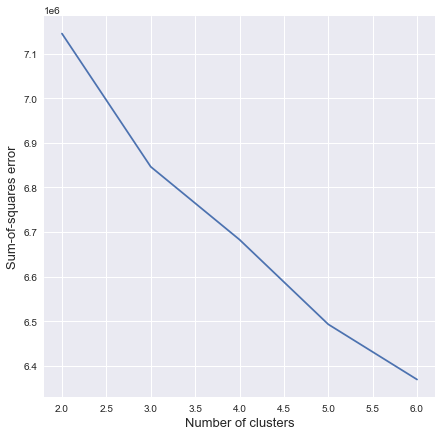

In [6]:
x_cols = df.to_numpy()

from sklearn.cluster import KMeans

xs = np.arange(2, 7, 1)
ys = []

for i in range(2, 7):
    kmeans = KMeans(n_clusters=i).fit(x_cols)
    ys.append(kmeans.inertia_)
    
fig = plt.figure(figsize=(7, 7))
plt.plot(xs, ys)
plt.xlabel('Number of clusters', fontsize=13)
plt.ylabel('Sum-of-squares error', fontsize=13)
plt.show()

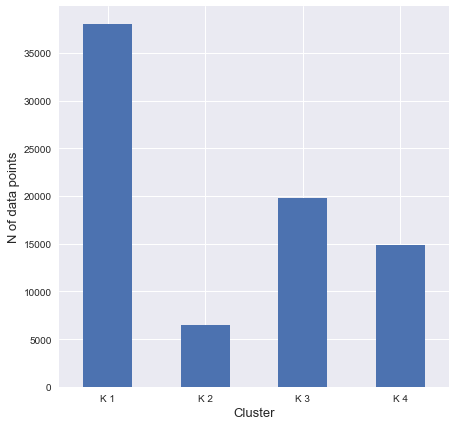

In [7]:
# Initializes the model with selected K, fit and predict the labels for the dataset
kmeans = KMeans(n_clusters=4, random_state=42).fit(x_cols)
labels = kmeans.predict(x_cols)

# Create a df with cluster id
kmeans_df = pd.DataFrame(labels, columns=['cluster_id'])

# Create plot
fig = plt.figure(figsize=(7, 7))
kmeans_df.value_counts().sort_index().plot.bar()
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('N of data points', fontsize=13)
plt.xticks(ticks=[0,1,2,3], labels=['K 1','K 2','K 3','K 4'], rotation=0)
plt.show()

Comparing clusters with some variables to understand customer segments main attributes.

In [8]:
# Reset index in original dataset
dfo.reset_index(inplace=True)

# Adds cluster labels to original dataset
dfo_labeled = dfo.join(kmeans_df)

In [9]:
# Group observations by cluster label and aggregate for most common value in categories
segments_df = dfo_labeled.groupby(by='cluster_id').agg(lambda x:x.value_counts().index[0])

In [10]:
segments_df.T

cluster_id,0,1,2,3
index,66602,53246,38909,34815
LeadTime,0,0,0,277
ArrivalDateMonth,August,August,October,September
StaysInWeekendNights,0,0,0,0
StaysInWeekNights,2,1,1,2
Adults,2,2,2,2
Children,0,0,0,0
Babies,0,0,0,0
Meal,BB,BB,BB,BB
Country,Other,PRT,PRT,PRT


## Visualizing clusters with PCA

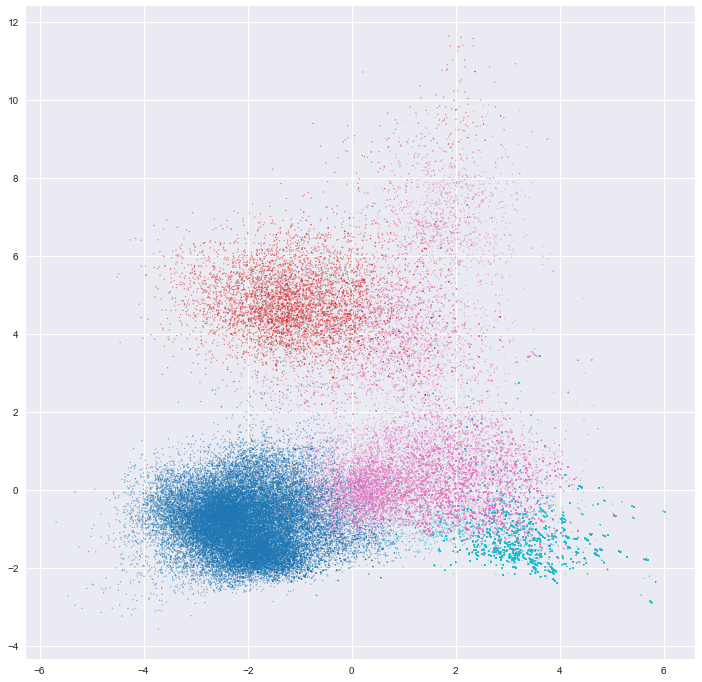

In [11]:
# Import PCA
from sklearn.decomposition import PCA

# Initialize the pca with 2 components and fit and transform the original dataset
pca = PCA(n_components=2)
x_new = pca.fit_transform(x_cols)

# Create df with the principal components and assign column names
pca_df = pd.DataFrame(x_new, columns=['x', 'y'])

# Join both df together
customer_seg = kmeans_df.join(pca_df)

fig = plt.figure(figsize=(12, 12))
plt.scatter('x', 'y', c='cluster_id', data=customer_seg, alpha=0.5, s=1, cmap='tab10')
plt.show()

Finding the optimal number of components for PCA

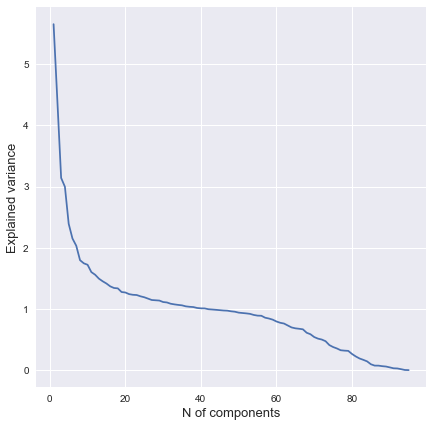

In [12]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Compute the explained variance by component
explained_variance = pca.explained_variance_

# Plot explained variance
fig = plt.figure(figsize=(7,7))
plt.plot(np.arange(1,96,1), explained_variance)
plt.xlabel('N of components', fontsize=13)
plt.ylabel('Explained variance', fontsize=13)
plt.show()

## Agglomerative hierarchical clustering 

In [ ]:
# Import algorithms
from sklearn.cluster import AgglomerativeClustering
